In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [120]:
root = os.getcwd()
data_path = "data/Garbage classification/"
data_dir = os.listdir(data_path)

imgs = []
labels = []
for label in data_dir:
    if label in ["cardboard", "glass", "metal"]:
        continue

    for img_path in os.listdir(os.path.join(root, data_path, label)):
        img = cv2.imread(os.path.join(data_path, label, img_path))
        resized = cv2.resize(img, (256, 256))
        imgs.append(resized)
        labels.append(label)

In [121]:
print(all([img.shape == imgs[0].shape for img in imgs]))
print(len(imgs) == len(labels))

True
True


In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size = 0.3, random_state = 242)

# Save images into train and test
if not os.path.isdir("test_imgs"):
    os.mkdir("test_imgs")

count = 0
for label, img in zip(y_test, X_test):
    cv2.imwrite(f"test_imgs/{label}_{count}.jpg", img)
    count += 1

# Normalize images
X_train = np.asarray(X_train) / 255
X_test = np.asarray(X_test) / 255

# Label encode target
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

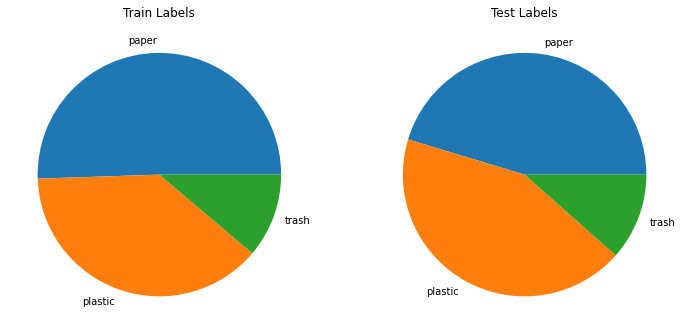

In [123]:
train_classes, train_class_counts = np.unique(y_train, return_counts = True) 
test_classes, test_class_counts = np.unique(y_test, return_counts = True)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 8))
axs[0].pie(train_class_counts, labels = encoder.classes_)
axs[0].set_title("Train Labels")

axs[1].pie(test_class_counts, labels = encoder.classes_)
axs[1].set_title("Test Labels")
plt.gcf().set_facecolor("white")
plt.show()

In [124]:
# Onehot encode target
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [131]:
from cnn_model import cnn
%load_ext autoreload
%autoreload 2

input_shape = X_train.shape[1: ]
output_shape = y_train.shape[1]

model = cnn(input_shape, output_shape)
model.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 256, 256, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 8)       520       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 flatten_17 (Flatten)        (None, 32768)             0         
                               

In [132]:
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 50)
model.save_weights("model_weights.h5")

Epoch 1/50
19/19 [==============================] - 30s 1s/step - loss: 7.6533 - Accuracy: 0.4091 - val_loss: 1.7240 - val_Accuracy: 0.5098
Epoch 2/50
19/19 [==============================] - 24s 1s/step - loss: 0.9921 - Accuracy: 0.5522 - val_loss: 0.9337 - val_Accuracy: 0.5294
Epoch 3/50
19/19 [==============================] - 24s 1s/step - loss: 0.7392 - Accuracy: 0.6364 - val_loss: 0.8021 - val_Accuracy: 0.5843
Epoch 4/50
19/19 [==============================] - 23s 1s/step - loss: 0.6897 - Accuracy: 0.6852 - val_loss: 0.7977 - val_Accuracy: 0.5765
Epoch 5/50
19/19 [==============================] - 23s 1s/step - loss: 0.6167 - Accuracy: 0.7037 - val_loss: 0.7321 - val_Accuracy: 0.7020
Epoch 6/50
19/19 [==============================] - 22s 1s/step - loss: 0.5490 - Accuracy: 0.7980 - val_loss: 0.7065 - val_Accuracy: 0.6706
Epoch 7/50
19/19 [==============================] - 23s 1s/step - loss: 0.4795 - Accuracy: 0.8333 - val_loss: 0.6728 - val_Accuracy: 0.7333
Epoch 8/50
19/19 [==

12/12 [==============================] - 5s 356ms/step


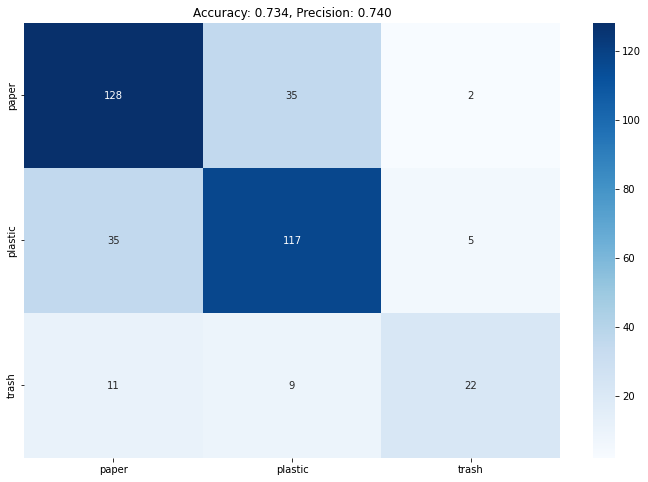

In [133]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis = 1)
y_true = np.argmax(y_test, axis = 1)

prec = precision_score(y_true, y_pred, average = "macro")
accr = accuracy_score(y_true, y_pred)

cnfm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12, 8))
plt.title(f"Accuracy: {accr:.3f}, Precision: {prec:.3f}")
sns.heatmap(
    cnfm, cmap = "Blues",
    annot = True, fmt = ".0f",
    xticklabels = encoder.classes_,
    yticklabels = encoder.classes_
)
plt.show()

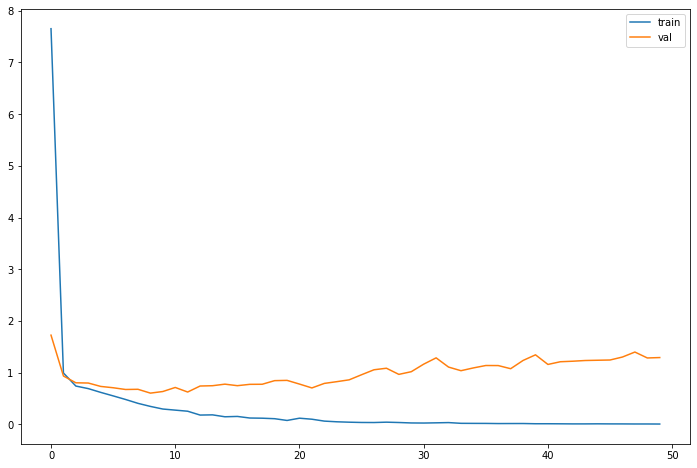

In [134]:
plt.figure(figsize = (12, 8))
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "val")
plt.legend()
plt.show()

In [141]:
chosen = X_test[0]

model.predict(np.asarray([chosen]))

1/1 [==============================] - 0s 141ms/step


array([[0.95748186, 0.9471174 , 0.01679762]], dtype=float32)